In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [2]:
root_path      = os.getcwd()
metrics_by_class_path = root_path + "\\metrics_by_class"
metrics_path   = root_path + "\\metrics"

Path(metrics_by_class_path).mkdir(parents = True, exist_ok = True)
Path(metrics_path).mkdir(parents = True, exist_ok = True)

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.rcParams["figure.figsize"] = (10, 6)
#plt.rcParams["font.family"] = "Times New Roman"

In [4]:
def add_metrics(df):
    df['GT']       = df['TP'] + df['FN']
    df['IoU']      = df['TP'] / (df['TP'] + df['FN'] + df['FP'])
    df['Accuracy'] = (df['TP'] + df['TN']) / (df['TP'] + df['FN'] + df['FP'] + df['TN'])
    
    return df

def mIoU(df):
    mIoU = df['IoU'].groupby(level = 0).agg(['mean'])
    mIoU.columns = ['mIoU']
    return mIoU

def fwIoU(df):
    fwIoU = (df['GT'] * df['IoU']).groupby(level=0).agg(['sum']) / df['GT'].groupby(level=0).agg(['sum'])
    fwIoU.columns = ['fwIoU']
    return fwIoU

def mAccuracy(df):
    mAcc = df['Accuracy'].groupby(level = 0).agg(['mean'])
    mAcc.columns = ['mAccuracy']
    return mAcc

#def fwAccuracy(df):
#    fwAcc = (df['GT'] * df['Accuracy']).groupby(level=0).agg(['sum']) / df['GT'].groupby(level=0).agg(['sum'])
#    fwAcc.columns = ['fwAccuracy']
#    return fwAcc

def read_csv(name):
    return add_metrics(pd.read_csv(name).set_index(['Threshold','Class']))

In [5]:
def plt_class_metric(dfs, t, names, metric, task, saving_path, order = None, 
                     ylim = 1, show = False, save = False):
    
    df = pd.concat([d[metric] for d in dfs], axis=1)
    df.columns = [f'{n} - {metric}' for n in names]
    
    if order is not None:
        df = df.reindex(df.index[order])
    
    fig, ax = plt.subplots()
    
    ind = np.arange(len(df))
    k = len(dfs)
    width = 0.6 / k
    
    for i, n in enumerate(names):
        ax.bar(ind + i*width, df[f'{n} - {metric}'], width, label = n)

    ax.set_ylabel(metric, fontsize = 12)
    ax.set_xlabel('Class', fontsize = 12)
    
    ax.legend()
    plt.xticks(ind + ((k-1)* width / k), df.index, rotation = 45)
    plt.ylim([0, ylim])

    if show:
        plt.show()
    if save:    
        fig.savefig(saving_path + f"\\{task}_segmentation_{metric}{t}.jpg")
        fig.savefig(saving_path + f"\\{task}_segmentation_{metric}{t}.eps")

In [6]:
def plt_metric(dfs, names, metric, task, saving_path, ylim = 1, show = False, save = False):
    
    fig, ax = plt.subplots()
    
    ind = np.arange(len(dfs[0]))
    k   = len(dfs)
    width = 0.6 / k
    
    for i, n in enumerate(names):
        ax.bar(ind + i*width, dfs[i][metric], width, label = n)

    ax.set_ylabel(metric, fontsize = 12)
    ax.set_xlabel('Threshold', fontsize = 12)
    
    ax.legend()
    plt.xticks(ind + ((k-1)* width / k), dfs[0].index)
    plt.ylim([0, ylim])

    if show:
        plt.show()
    if save:
        flag = 'I' if "IoU" in metric else 'A'
        
        fig.savefig(saving_path + f"\\{task}_segmentation_{flag}_{metric}.jpg")
        fig.savefig(saving_path + f"\\{task}_segmentation_{flag}_{metric}.eps")

In [7]:
ogc         = read_csv('object_grabcut.csv')
ogcam_PF_PB = read_csv('object_grabcutcam_PF_PB.csv')
ogcam_F_PF  = read_csv('object_grabcutcam_F_PF.csv')
ogcam_F_PB  = read_csv('object_grabcutcam_F_PB.csv')

ccam        = read_csv('class_cam.csv')
cgcam_PF_PB = read_csv('class_grabcutcam_PF_PB.csv')
cgcam_F_PF  = read_csv('class_grabcutcam_F_PF.csv')
cgcam_F_PB  = read_csv('class_grabcutcam_F_PB.csv')

In [8]:
def ranking_class(dfs):
    IoU_rank = np.zeros(20)
    Acc_rank = np.zeros(20)
    
    for df in dfs:
        df = df[['IoU', 'Accuracy']].groupby(level = 1).agg(['mean'])
        dfIoU = df['IoU']['mean']
        dfAcc = df['Accuracy']['mean']
        IoU_rank = np.add(IoU_rank, dfIoU.tolist() / dfIoU.mean())
        Acc_rank = np.add(IoU_rank, dfAcc.tolist() / dfAcc.mean())
        
    return np.argsort(- IoU_rank), np.argsort(- Acc_rank)

In [9]:
dfs = [ogc, ogcam_PF_PB, ogcam_F_PF, ogcam_F_PB, ccam, cgcam_PF_PB, cgcam_F_PF, cgcam_F_PB]

thresholds     = (np.arange(1, 10) / 10).tolist()
class_metrics  = ['IoU', 'Accuracy']
class_rank     = ranking_class(dfs)
metrics        = ['mIoU', 'fwIoU', 'mAccuracy']
metrics_fun    = [mIoU, fwIoU, mAccuracy]

ob_techs       = [ogcam_PF_PB, ogcam_F_PF, ogcam_F_PB]
ob_techs_names = ['grabcut-cam PF PB', 'grabcut-cam F PF', 'grabcut-cam F PB']

c_techs        = [ccam, cgcam_PF_PB, cgcam_F_PF, cgcam_F_PB]
c_techs_names  = ['cam', 'grabcut-cam PF PB', 'grabcut-cam F PF', 'grabcut-cam F PB']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


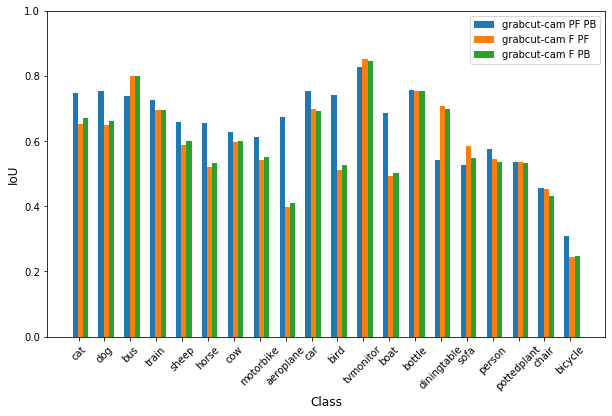

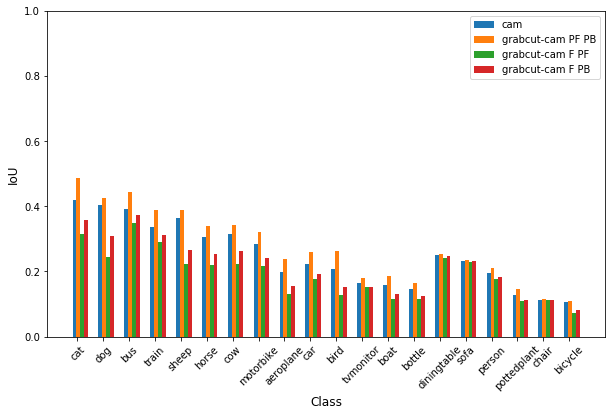

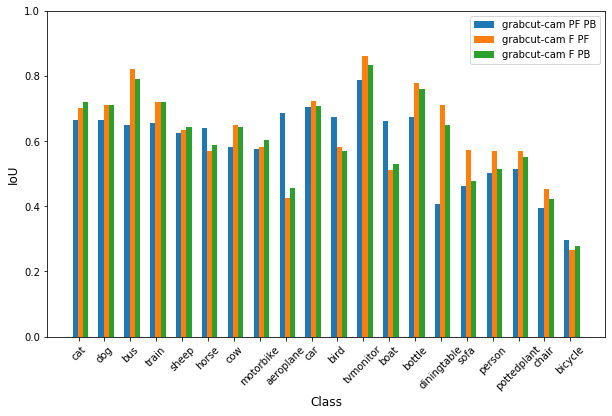

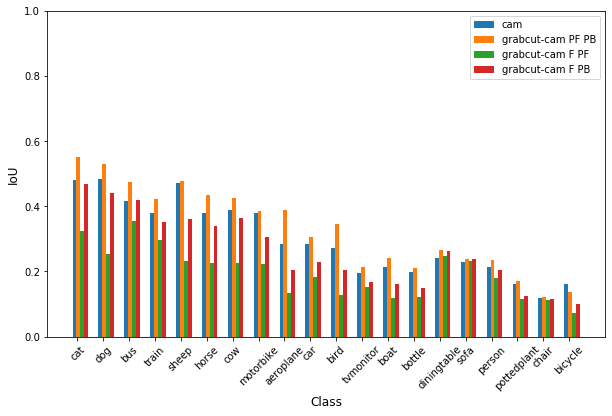

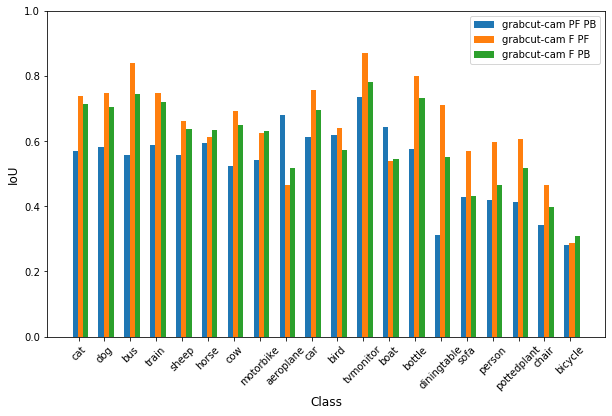

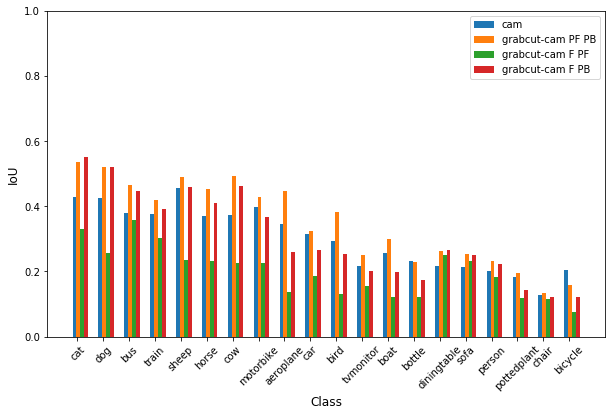

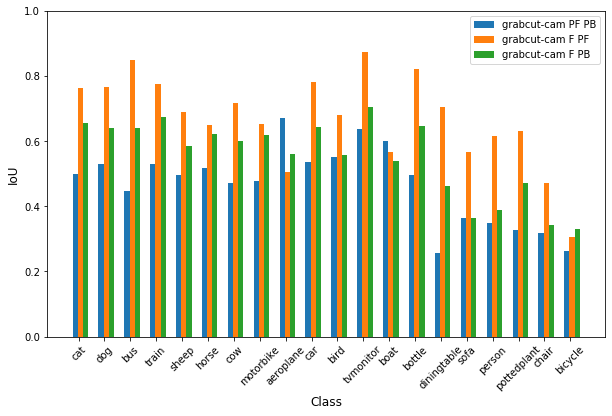

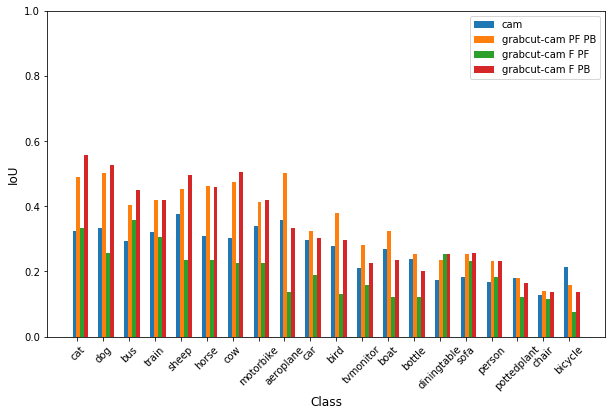

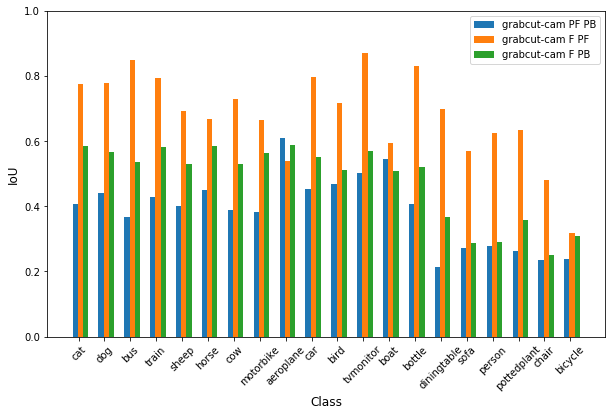

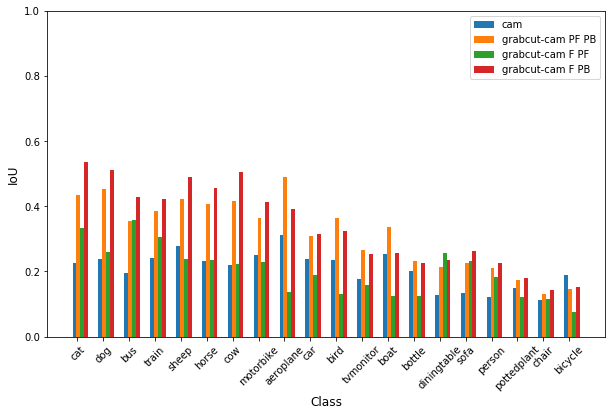

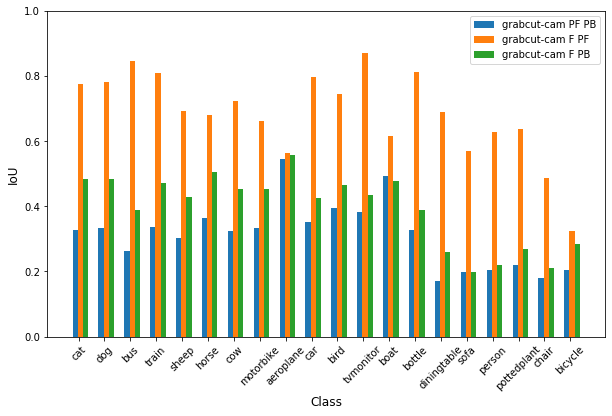

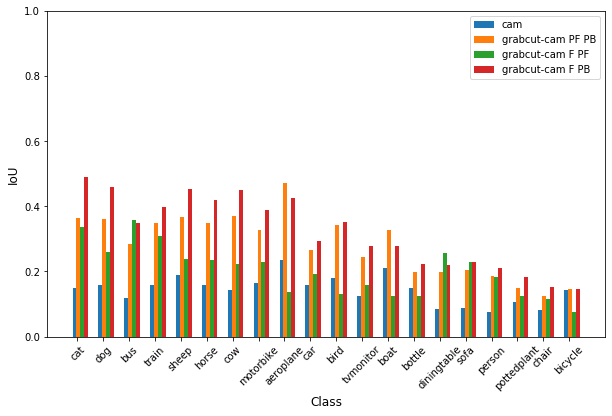

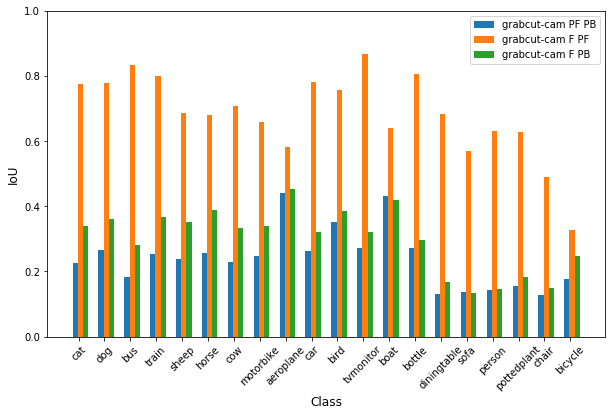

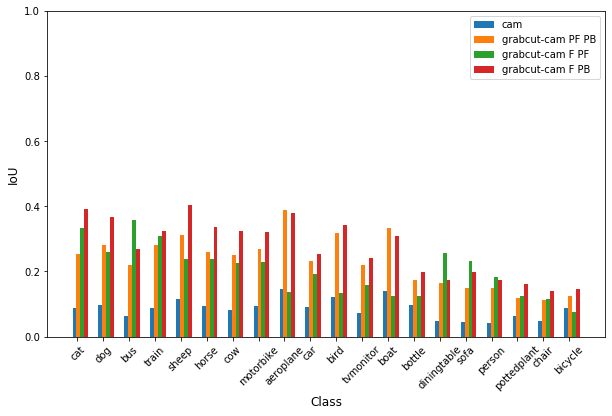

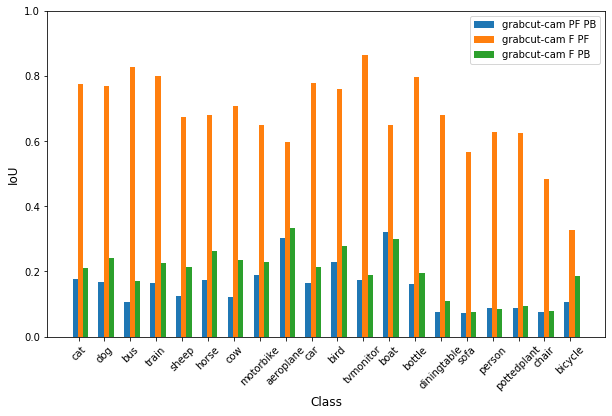

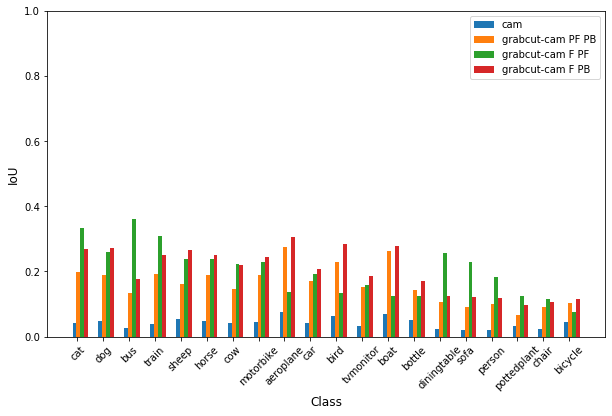

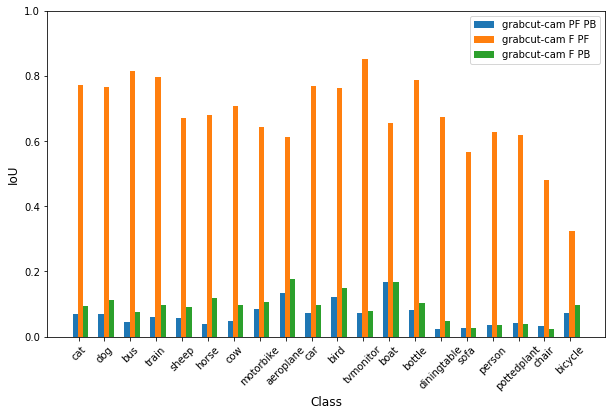

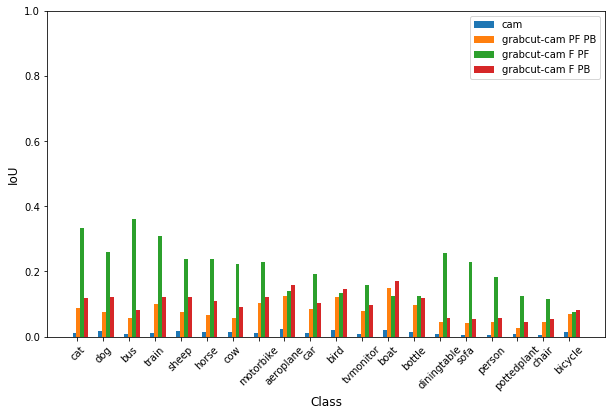

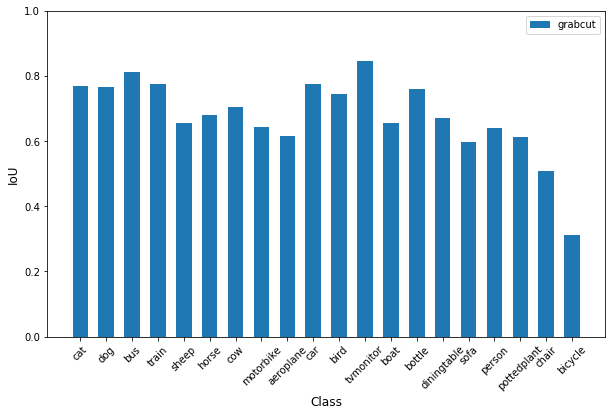

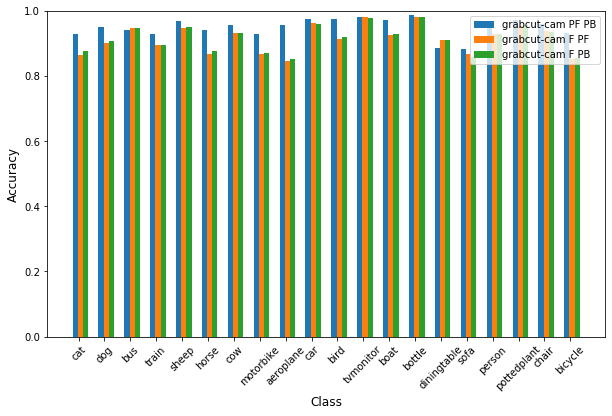

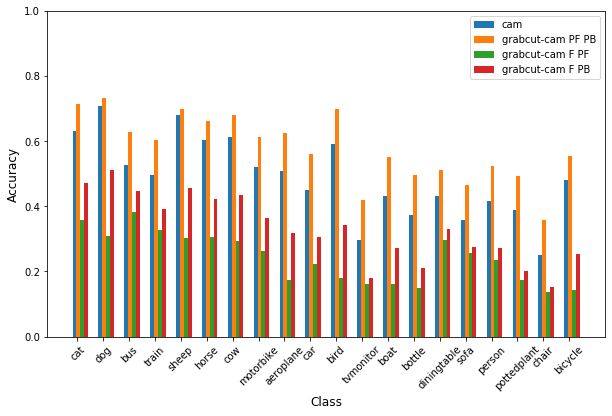

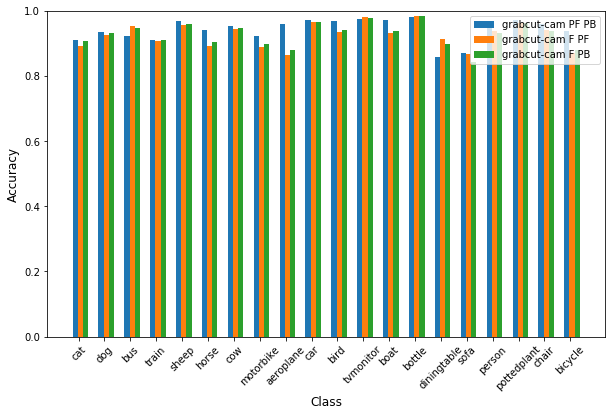

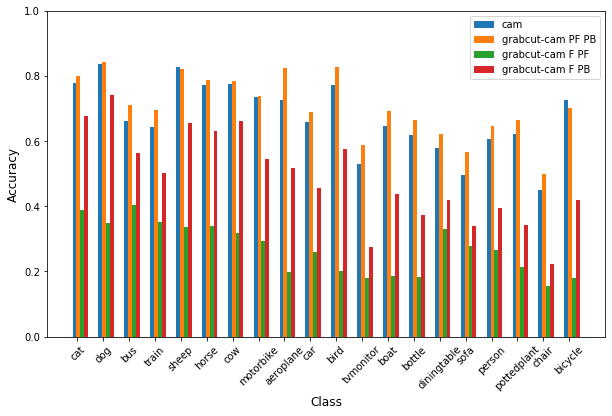

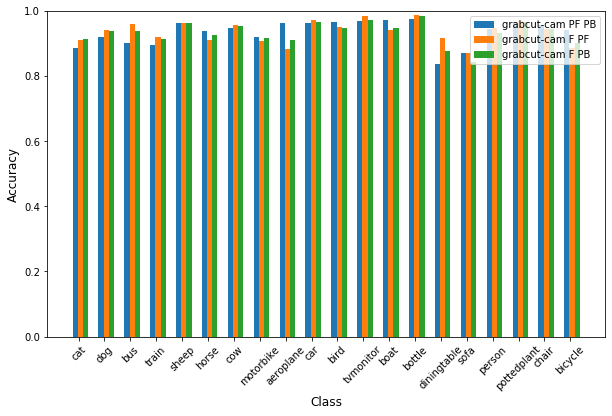

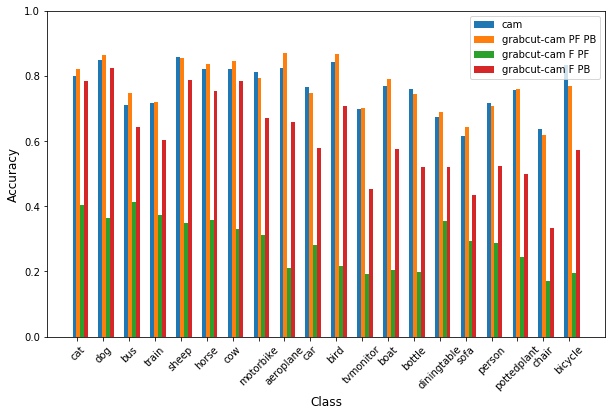

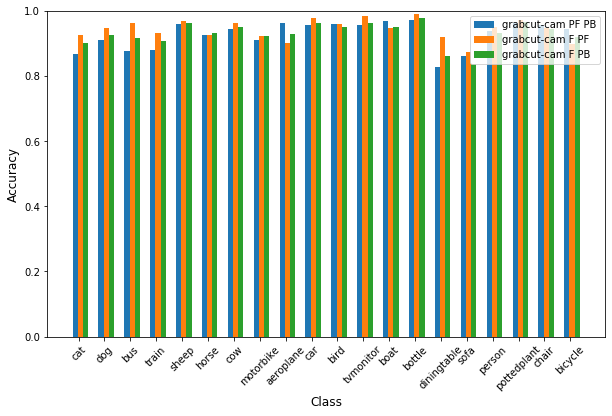

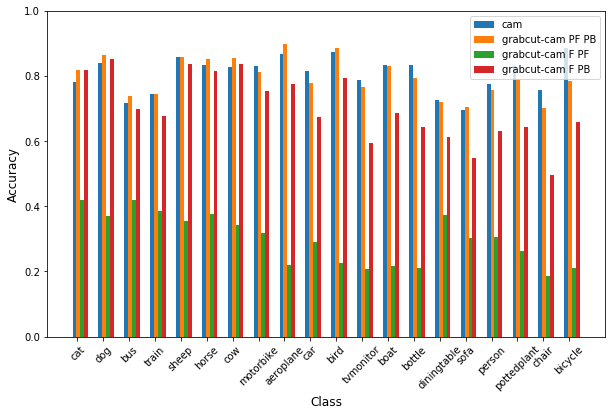

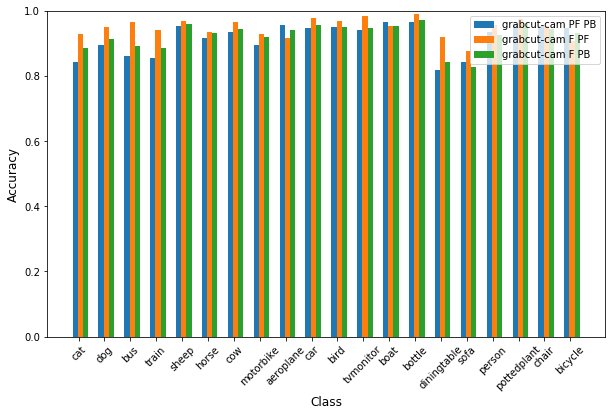

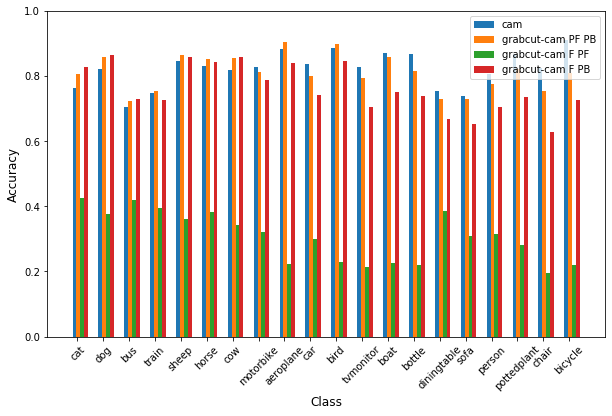

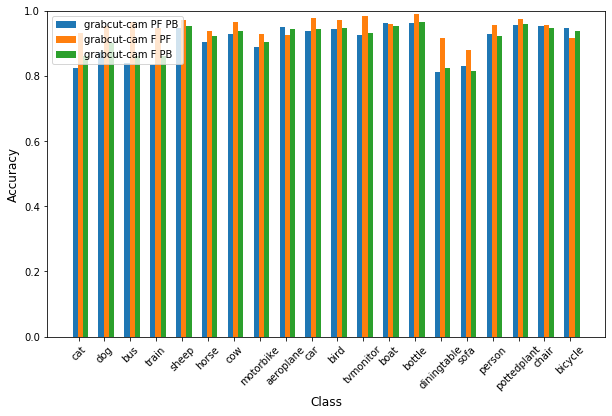

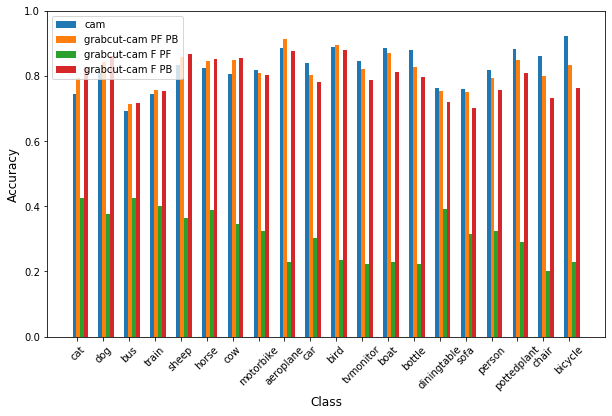

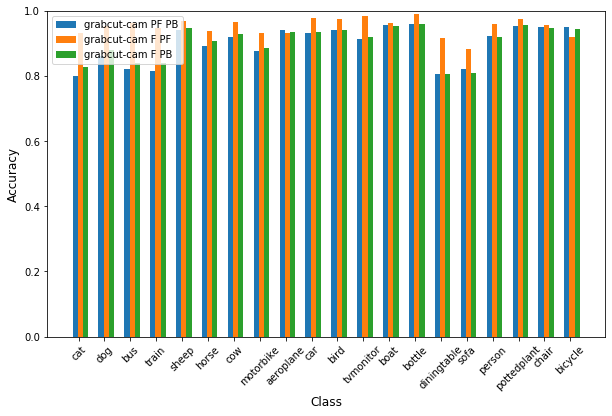

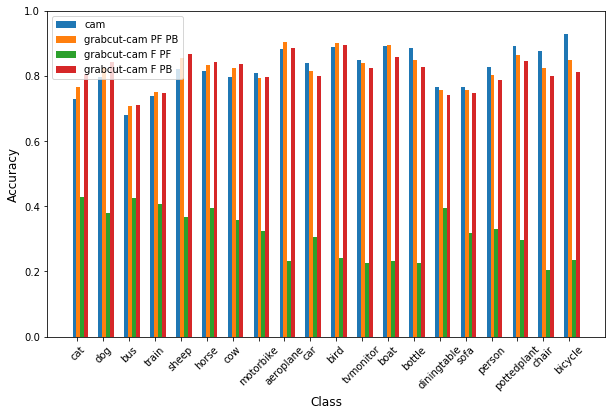

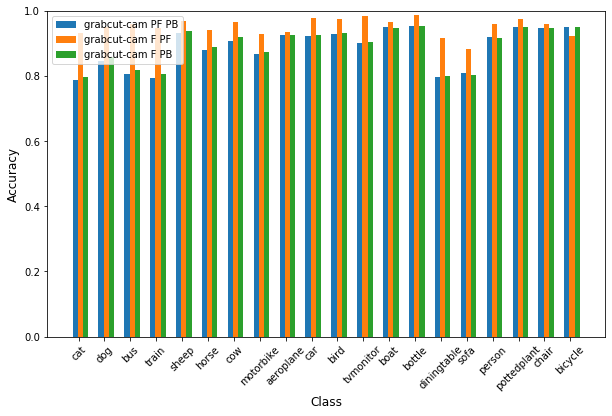

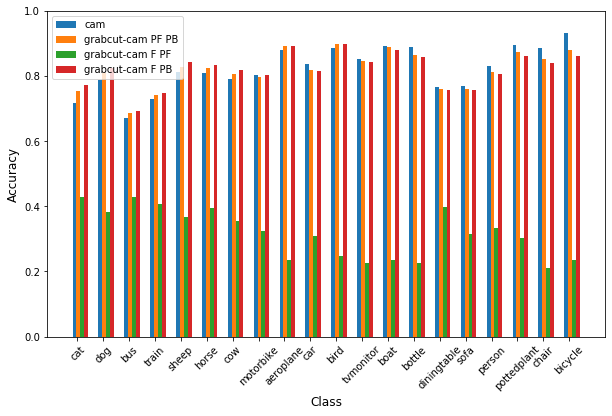

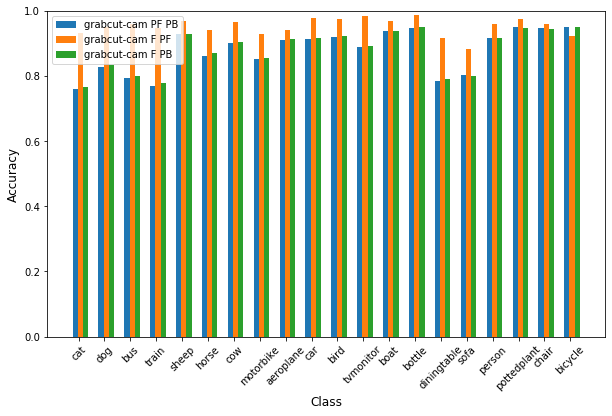

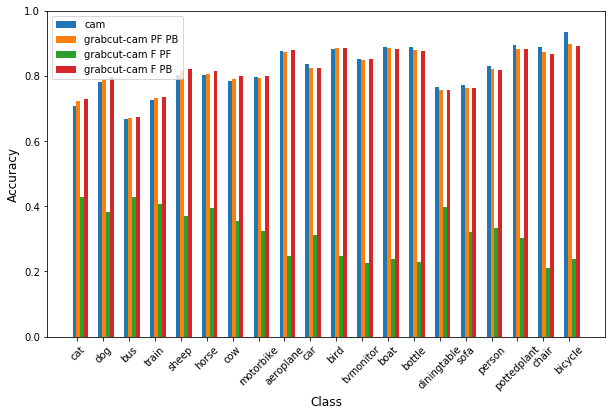

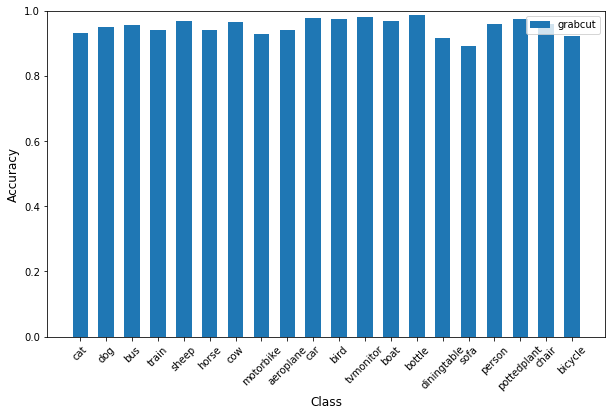

In [10]:
for (m, r) in zip(class_metrics, class_rank):
    for t in thresholds:
        plt_class_metric([df.loc[t] for df in ob_techs],
                         f'_0{int(t*10)}', 
                         ob_techs_names, 
                         m,
                         'Object', metrics_by_class_path,
                         order = r,
                         ylim = 1, show = False, save = True)
        
        plt_class_metric([df.loc[t] for df in c_techs],
                         f'_0{int(t*10)}', 
                         c_techs_names, 
                         m,
                         'Class', metrics_by_class_path,
                         order = r,
                         ylim = 1, show = False, save = True)
    
    plt_class_metric([ogc.loc['-']],
                     "", 
                     ['grabcut'], 
                     m,
                     'Object', metrics_by_class_path,
                     order = r,
                     ylim = 1, show = False, save = True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

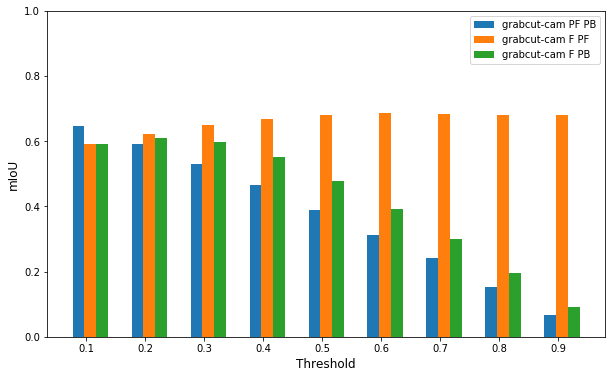

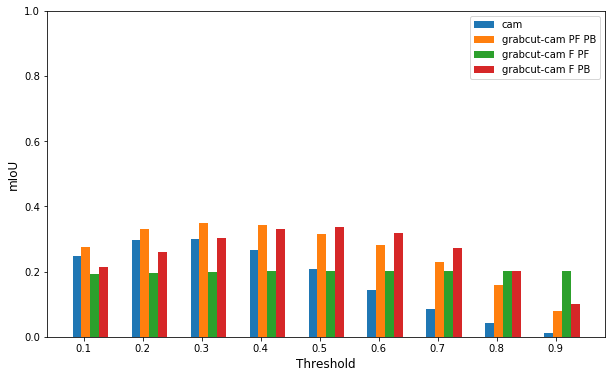

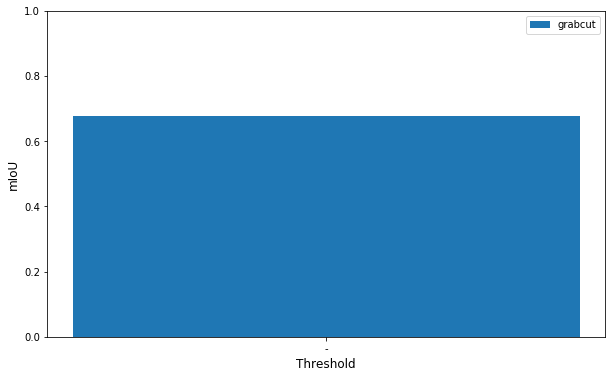

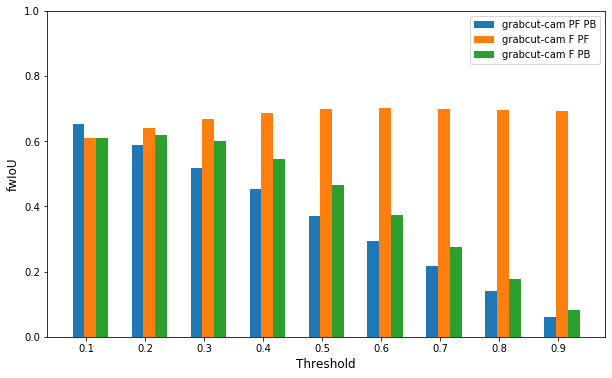

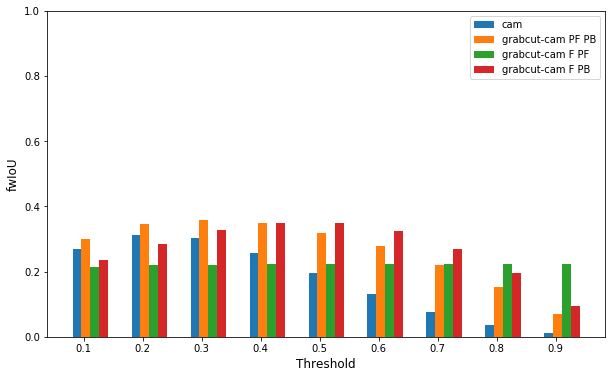

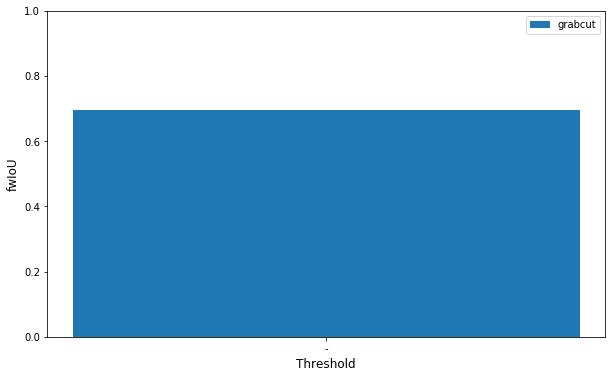

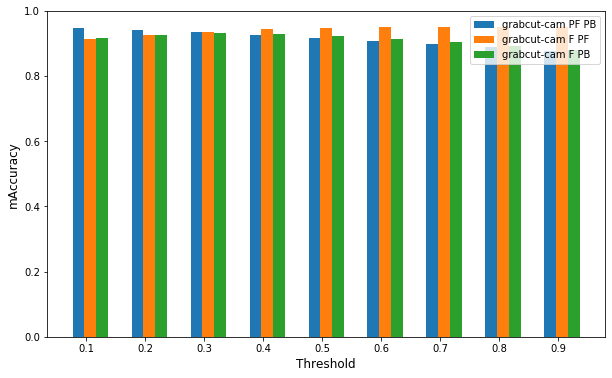

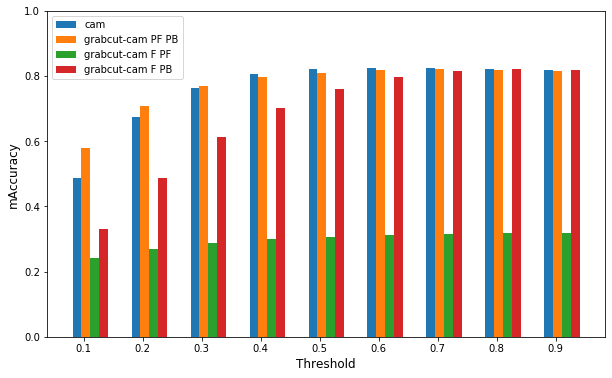

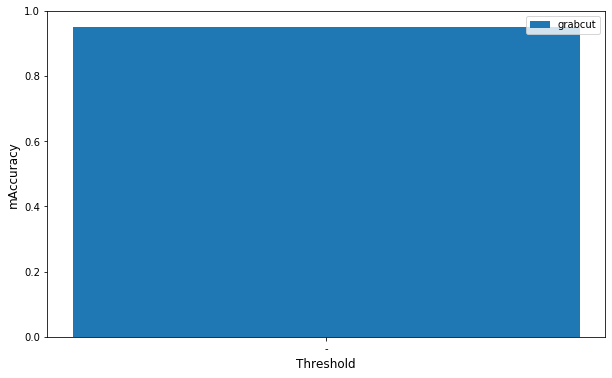

In [11]:
for (m, f) in zip(metrics, metrics_fun):
    plt_metric([f(df) for df in ob_techs], 
               ob_techs_names, 
               m, 
               'Object_grabcutcam', 
               metrics_path, ylim = 1, show = False, save = True)
    
    plt_metric([f(df) for df in c_techs], 
               c_techs_names, 
               m, 
               'Class', 
               metrics_path, ylim = 1, show = False, save = True)
    
    plt_metric([f(ogc)], 
               ['grabcut'], 
               m, 
               'Object_grabcut', 
               metrics_path, ylim = 1, show = False, save = True)